# Superconduct dataset - linear regression

The objective value and the all gradient descents are saved in a pickle file. Thus, it is possible to play with results without need to recompute everything (it takes several hours). 
However, the transformed data is not saved because it can be generated without random. Thus to regenerate figures, be sure to intialy run the first cells of the notebook (those devoted to data preparation).

In [1]:
# Add below current directory to path
# Notebook cannot import any code without this line !!!!
import sys; sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import IntSlider, interact
from math import sqrt

from sklearn.preprocessing import scale

from tqdm import tqdm, trange # For progress bar
%matplotlib inline
%load_ext autoreload
%autoreload 2

from src.models.CostModel import LogisticModel, RMSEModel

from src.machinery.GradientDescent import ArtemisDescent, FL_VanillaSGD
from src.machinery.GradientUpdateMethod import ArtemisUpdate
from src.machinery.Parameters import *
from src.machinery.PredefinedParameters import *

from src.utils.ErrorPlotter import *
from src.utils.Constants import *
from src.utils.DataClustering import *
from src.utils.DataPreparation import build_data_logistic, add_bias_term
from src.utils.Utilities import pickle_loader, pickle_saver
from src.utils.runner.RunnerUtilities import *
from src.utils.runner.ResultsOfSeveralDescents import ResultsOfSeveralDescents

filename = "superconduct"

nb_devices_for_the_run = 10
MAX_NB_DEVICES = 10

In [2]:
import pandas as pd
data = pd.read_csv('../dataset/superconduct/train.csv', sep=",")
data.head()

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,...,wtd_mean_Valence,gmean_Valence,wtd_gmean_Valence,entropy_Valence,wtd_entropy_Valence,range_Valence,wtd_range_Valence,std_Valence,wtd_std_Valence,critical_temp
0,4,88.944468,57.862692,66.361592,36.116612,1.181795,1.062396,122.90607,31.794921,51.968828,...,2.257143,2.213364,2.219783,1.368922,1.066221,1,1.085714,0.433013,0.437059,29.0
1,5,92.729214,58.518416,73.132787,36.396602,1.449309,1.057755,122.90607,36.161939,47.094633,...,2.257143,1.888175,2.210679,1.557113,1.047221,2,1.128571,0.632456,0.468606,26.0
2,4,88.944468,57.885242,66.361592,36.122509,1.181795,0.975980,122.90607,35.741099,51.968828,...,2.271429,2.213364,2.232679,1.368922,1.029175,1,1.114286,0.433013,0.444697,19.0
3,4,88.944468,57.873967,66.361592,36.119560,1.181795,1.022291,122.90607,33.768010,51.968828,...,2.264286,2.213364,2.226222,1.368922,1.048834,1,1.100000,0.433013,0.440952,22.0
4,4,88.944468,57.840143,66.361592,36.110716,1.181795,1.129224,122.90607,27.848743,51.968828,...,2.242857,2.213364,2.206963,1.368922,1.096052,1,1.057143,0.433013,0.428809,23.0


In [3]:
print(data.columns.values)

['number_of_elements' 'mean_atomic_mass' 'wtd_mean_atomic_mass'
 'gmean_atomic_mass' 'wtd_gmean_atomic_mass' 'entropy_atomic_mass'
 'wtd_entropy_atomic_mass' 'range_atomic_mass' 'wtd_range_atomic_mass'
 'std_atomic_mass' 'wtd_std_atomic_mass' 'mean_fie' 'wtd_mean_fie'
 'gmean_fie' 'wtd_gmean_fie' 'entropy_fie' 'wtd_entropy_fie' 'range_fie'
 'wtd_range_fie' 'std_fie' 'wtd_std_fie' 'mean_atomic_radius'
 'wtd_mean_atomic_radius' 'gmean_atomic_radius' 'wtd_gmean_atomic_radius'
 'entropy_atomic_radius' 'wtd_entropy_atomic_radius' 'range_atomic_radius'
 'wtd_range_atomic_radius' 'std_atomic_radius' 'wtd_std_atomic_radius'
 'mean_Density' 'wtd_mean_Density' 'gmean_Density' 'wtd_gmean_Density'
 'entropy_Density' 'wtd_entropy_Density' 'range_Density'
 'wtd_range_Density' 'std_Density' 'wtd_std_Density'
 'mean_ElectronAffinity' 'wtd_mean_ElectronAffinity'
 'gmean_ElectronAffinity' 'wtd_gmean_ElectronAffinity'
 'entropy_ElectronAffinity' 'wtd_entropy_ElectronAffinity'
 'range_ElectronAffinity' 'w

In [4]:
with pd.option_context('display.max_columns', 80):
    print(data.describe(include='all'))

       number_of_elements  mean_atomic_mass  wtd_mean_atomic_mass  \
count        21263.000000      21263.000000          21263.000000   
mean             4.115224         87.557631             72.988310   
std              1.439295         29.676497             33.490406   
min              1.000000          6.941000              6.423452   
25%              3.000000         72.458076             52.143839   
50%              4.000000         84.922750             60.696571   
75%              5.000000        100.404410             86.103540   
max              9.000000        208.980400            208.980400   

       gmean_atomic_mass  wtd_gmean_atomic_mass  entropy_atomic_mass  \
count       21263.000000           21263.000000         21263.000000   
mean           71.290627              58.539916             1.165608   
std            31.030272              36.651067             0.364930   
min             5.320573               1.960849             0.000000   
25%            58.

In [5]:
dim_notebook = len(data.columns) - 1
print("There is " + str(dim_notebook) + " dimensions.")

There is 81 dimensions.


In [6]:
if data.isnull().values.any():
    print("There is missing value.")
else:
    print("No missing value. Great !")

No missing value. Great !


In [7]:
X_data = data.loc[:, data.columns != "critical_temp"]
Y_data = data.loc[:, data.columns == "critical_temp"]
dim_notebook = len(X_data.columns)
print("There is " + str(dim_notebook) + " dimensions.")

There is 81 dimensions.


In [8]:
#Data normalisation
X_data = scale(X_data)
Y_data = scale(Y_data)

In [9]:
X_data

array([[-0.0800575 ,  0.04673292, -0.45165095, ..., -0.40616628,
        -0.83837245, -0.52006971],
       [ 0.6147436 ,  0.17426938, -0.43207104, ..., -0.36235194,
        -0.42686578, -0.45082134],
       [-0.0800575 ,  0.04673292, -0.45097762, ..., -0.37695672,
        -0.83837245, -0.50330427],
       ...,
       [-1.46965972,  0.40792698,  0.67545689, ...,  1.75534096,
        -0.7001588 , -0.60141582],
       [-1.46965972,  0.40792698,  0.71984372, ...,  0.7432298 ,
        -0.7001588 , -0.46423977],
       [-0.77485861, -0.0030091 ,  0.41416385, ...,  0.32407265,
         1.18612097,  1.81314381]])

In [10]:
torch.tensor(X_data, dtype=torch.float64)

tensor([[-0.0801,  0.0467, -0.4517,  ..., -0.4062, -0.8384, -0.5201],
        [ 0.6147,  0.1743, -0.4321,  ..., -0.3624, -0.4269, -0.4508],
        [-0.0801,  0.0467, -0.4510,  ..., -0.3770, -0.8384, -0.5033],
        ...,
        [-1.4697,  0.4079,  0.6755,  ...,  1.7553, -0.7002, -0.6014],
        [-1.4697,  0.4079,  0.7198,  ...,  0.7432, -0.7002, -0.4642],
        [-0.7749, -0.0030,  0.4142,  ...,  0.3241,  1.1861,  1.8131]],
       dtype=torch.float64)

In [11]:
X_merged = torch.tensor(X_data, dtype=torch.float64)
Y_merged = torch.tensor(Y_data, dtype=torch.float64)
number_of_items = len(X_merged)
number_of_items_by_devices = number_of_items // nb_devices_for_the_run
print("Number of points by devices: ", number_of_items_by_devices)

X, Y = [], []
for i in range(nb_devices_for_the_run):
    X.append(X_merged[number_of_items_by_devices * i:number_of_items_by_devices * (i+1)])
    Y_temp = Y_merged[number_of_items_by_devices * i:number_of_items_by_devices * (i+1)]
    Y.append(torch.stack([y[0] for y in Y_temp]))
print("There is " + str(len(X)) + " devices.")


# Adding a columns of "1" to take into account a potential bias.
X = add_bias_term(X)
print(X[0].shape)

Number of points by devices:  2126
There is 10 devices.
torch.Size([2126, 82])


In [12]:
%%time
obj_min_by_N = {}
for nb_devices in tqdm([10]):
    obj_min_by_N_descent = FL_VanillaSGD(Parameters(n_dimensions = dim_notebook + 1, 
                                                     nb_devices=nb_devices,
                                                     nb_epoch=20000, 
                                                     quantization_param=0,
                                                     momentum = 0., 
                                                     verbose=True, 
                                                     cost_model=RMSEModel(),
                                                     stochastic=False,
                                                     bidirectional=False
                                                    ))
    obj_min_by_N_descent.set_data(X[:nb_devices],Y[:nb_devices])
    obj_min_by_N_descent.run()
    obj_min_by_N[nb_devices] = obj_min_by_N_descent.losses[-1]
pickle_saver(obj_min_by_N, filename + "-obj_min")

  0%|          | 0/1 [00:00<?, ?it/s]

Large dimension...
   it    |   obj   
    4000 | 2.7702e-01
    8000 | 2.7102e-01
   12000 | 2.6850e-01
   16000 | 2.6717e-01


100%|██████████| 1/1 [01:53<00:00, 113.21s/it]

Gradient Descent: execution time=113.191 seconds
Final loss :  0.266367082297802

CPU times: user 7min 29s, sys: 2.35 s, total: 7min 31s
Wall time: 1min 53s


Text(0.5, 0, 'true value (normalized)')

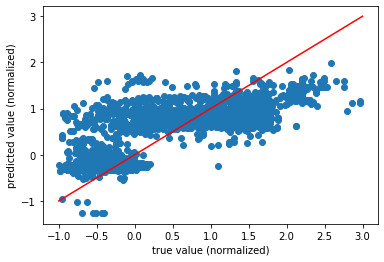

In [13]:
plt.scatter(Y[0], X[0].mv(obj_min_by_N_descent.model_params[-1]))
plt.plot(np.linspace(-1, 3, 2), np.linspace(-1, 3, 2), color='r')
plt.ylabel("predicted value (normalized)")
plt.xlabel("true value (normalized)")

In [14]:
%%time
all_descent = {}
myX = X[:nb_devices_for_the_run]
myY = Y[:nb_devices_for_the_run]
X_number_of_bits = []
for type_params in tqdm(KIND_COMPRESSION):
    multiple_sg_descent = multiple_run_descent(type_params, myX, myY, model = RMSEModel(), 
                                               use_averaging=True)
    all_descent[type_params.name()] = multiple_sg_descent
res = ResultsOfSeveralDescents(all_descent, nb_devices_for_the_run)
pickle_saver(res, filename + "-descent")

  0%|          | 0/5 [00:00<?, ?it/s]

SGD
Large dimension...
Large dimension...


 20%|██        | 1/5 [10:32<42:09, 632.27s/it]

QSGD
Large dimension...
Large dimension...


 40%|████      | 2/5 [24:28<34:40, 693.52s/it]

Diana
Large dimension...
Large dimension...


 60%|██████    | 3/5 [38:40<24:41, 740.96s/it]

BiQSGD
Large dimension...
Large dimension...


 80%|████████  | 4/5 [52:36<12:49, 769.65s/it]

Artemis
Large dimension...
Large dimension...


100%|██████████| 5/5 [1:06:25<00:00, 797.03s/it]

CPU times: user 1h 19min 20s, sys: 2min 29s, total: 1h 21min 49s
Wall time: 1h 6min 25s


In [15]:
print("Model obtain from Vanilla SGD descent, the first value corresponds to the bias: ")
print(res.all_final_model[0])

Model obtain from Vanilla SGD descent, the first value corresponds to the bias: 
tensor([-1.7581e-03,  5.7176e-02,  6.3245e-02, -1.5648e-02,  2.6085e-02,
         2.4010e-02, -7.7144e-02,  1.4873e-01,  1.8971e-01, -7.3667e-02,
         8.2372e-02, -1.2355e-01,  3.3239e-02, -8.5313e-03,  5.5674e-02,
         1.7434e-03,  1.0356e-02,  1.2408e-02,  8.7964e-02,  3.1846e-02,
        -7.7532e-02, -6.6065e-02,  1.1598e-02,  1.2740e-01, -6.2635e-02,
         3.0132e-02, -4.0499e-03,  1.1468e-01,  1.7398e-01, -1.0069e-01,
        -9.0860e-03,  8.4112e-02, -8.2652e-02, -1.0756e-02, -7.1896e-02,
         9.4142e-03, -3.4768e-02, -1.1399e-01, -2.6980e-02,  1.0021e-01,
        -9.9115e-03, -7.1076e-02,  7.9957e-02,  6.9172e-02,  2.4609e-05,
        -1.4671e-01, -1.0536e-01, -1.9304e-01, -1.1280e-01, -1.0856e-01,
         1.0081e-01, -3.7834e-02,  3.5869e-02,  1.1914e-03, -2.2272e-02,
        -3.7957e-03,  9.1418e-03,  1.3532e-01, -4.6184e-02,  5.3547e-02,
         7.9019e-03, -7.6559e-02,  5.5206e-

## With averaging

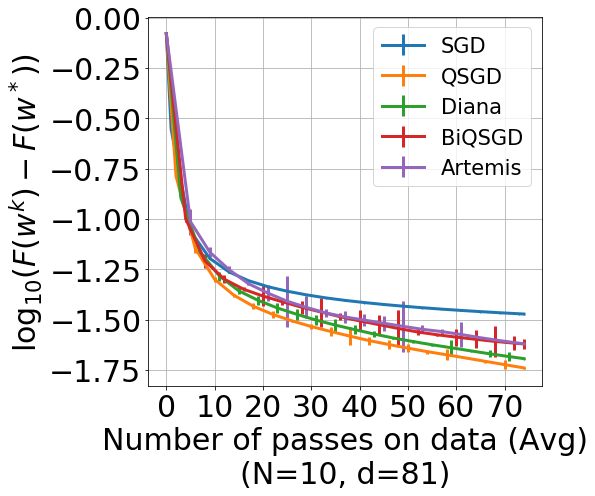

In [14]:
myX = X[:nb_devices_for_the_run]
myY = Y[:nb_devices_for_the_run]
obj_min_by_N = pickle_loader(filename + "-obj_min")
res = pickle_loader(filename + "-descent")
obj = obj_min_by_N[len(myX)]

plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, 
                dim_notebook, all_error=res.get_std(obj, averaged=False), x_legend="Number of passes on data (Avg)") 

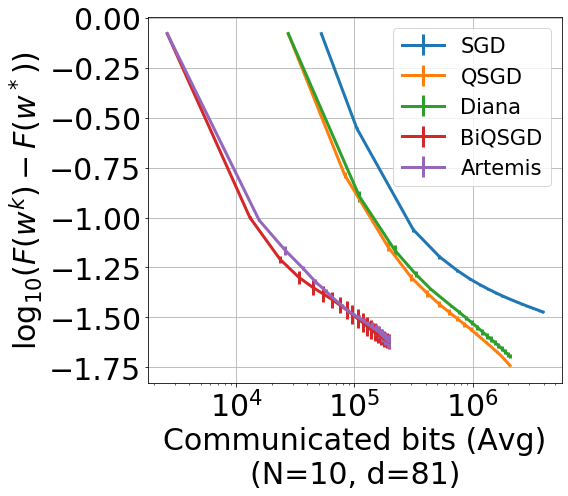

In [15]:
plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, dim_notebook, 
                x_points=res.X_number_of_bits, all_error=res.get_std(obj, averaged=True), x_legend="Communicated bits (Avg)") 


## Without averaging

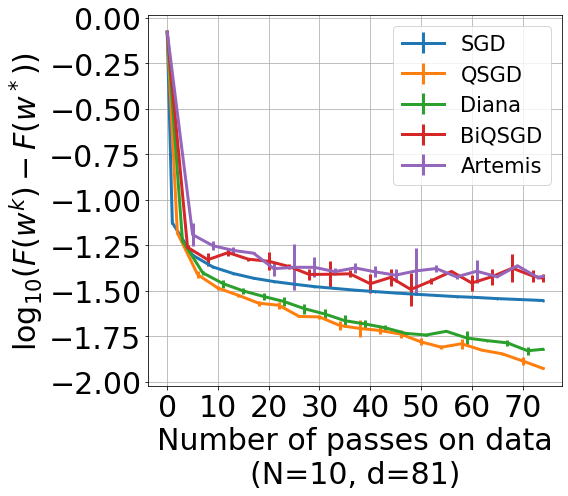

In [16]:
myX = X[:nb_devices_for_the_run]
myY = Y[:nb_devices_for_the_run]
obj_min_by_N = pickle_loader(filename + "-obj_min")
res = pickle_loader(filename + "-descent")
obj = obj_min_by_N[len(myX)]

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook,
               all_error=res.get_std(obj)) 

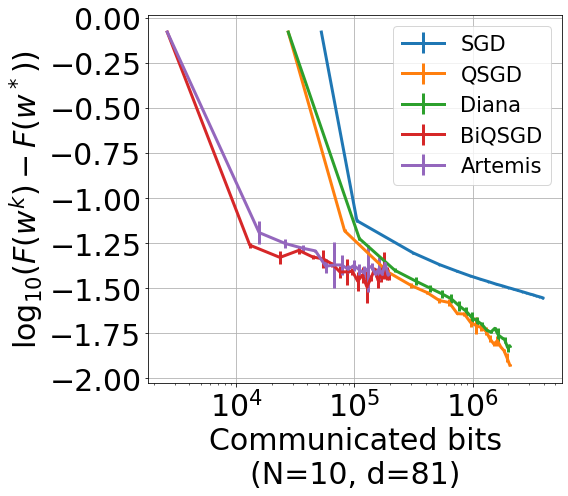

In [17]:
plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook, 
                x_points=res.X_number_of_bits, x_legend="Communicated bits", all_error=res.get_std(obj)) 

# Handling non-iid data

CPU times: user 4min 51s, sys: 1.15 s, total: 4min 52s
Wall time: 1min 32s


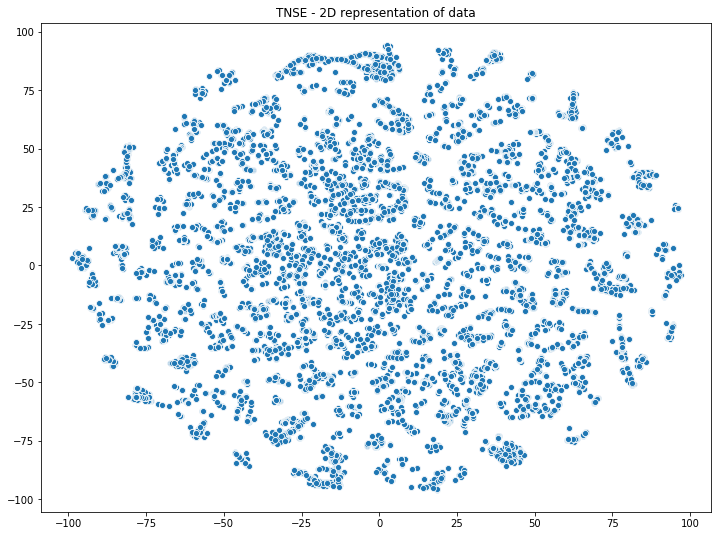

In [19]:
%%time
# Running TNSE to obtain a 2D representation of data
embedded_data = tnse(data)

There is 10 devices.
Number of points on device 0 : 2213
Number of points on device 1 : 4927
Number of points on device 2 : 2531
Number of points on device 3 : 1410
Number of points on device 4 : 2201
Number of points on device 5 : 850
Number of points on device 6 : 1153
Number of points on device 7 : 1296
Number of points on device 8 : 3134
Number of points on device 9 : 1548
CPU times: user 31 s, sys: 268 ms, total: 31.3 s
Wall time: 7.89 s


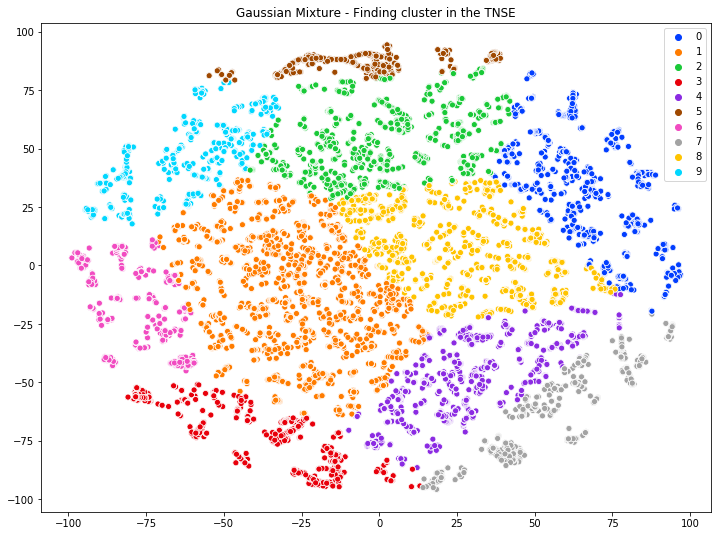

In [20]:
%%time
nb_cluster = 10
# Finding cluster in the TNSE
predicted_cluster = find_cluster(embedded_data, nb_cluster)
# With the found clusters, splitting data. 
X, Y = clustering_data(data, predicted_cluster, "critical_temp", nb_cluster, scale_Y=True)
dim_notebook = X[0].shape[1]

CPU times: user 4min 18s, sys: 796 ms, total: 4min 18s
Wall time: 1min 24s


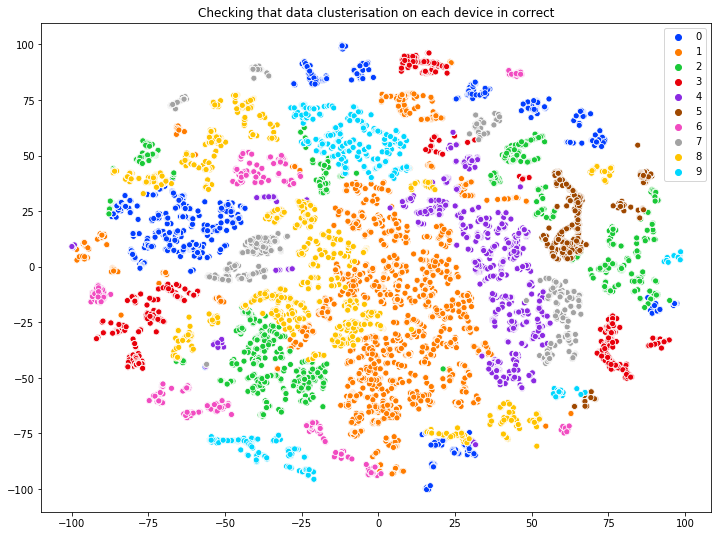

In [21]:
%%time
#Checking that splitting data by cluster is valid.
check_data_clusterisation(X,Y, nb_cluster)

In [27]:
%%time
obj_min_by_N = {}

obj_min_by_N_descent = FL_VanillaSGD(Parameters(n_dimensions = dim_notebook, 
                                                     nb_devices=nb_devices,
                                                     nb_epoch=20000, 
                                                     quantization_param=0,
                                                     momentum = 0., 
                                                     verbose=True, 
                                                     cost_model=RMSEModel(),
                                                     stochastic=False,
                                                     bidirectional=False
                                                    ))
obj_min_by_N_descent.set_data(X[:nb_devices],Y[:nb_devices])
obj_min_by_N_descent.run()
obj_min_by_N[nb_devices] = obj_min_by_N_descent.losses[-1]

pickle_saver(obj_min_by_N, filename + "-noniid-obj_min")

Large dimension...
   it    |   obj   
    4000 | 2.9278e-01
    8000 | 2.8651e-01
   12000 | 2.8384e-01
   16000 | 2.8239e-01
Gradient Descent: execution time=129.865 seconds
Final loss :  0.281489385664463

CPU times: user 8min 35s, sys: 2.64 s, total: 8min 38s
Wall time: 2min 9s


In [22]:
%%time
all_descent = {}
X_number_of_bits = []
for type_params in tqdm(KIND_COMPRESSION):
    multiple_sg_descent = multiple_run_descent(type_params, X, Y, model = RMSEModel(), 
                                               use_averaging=True, stochastic=False, nb_epoch=400)
    all_descent[type_params.name()] = multiple_sg_descent
res = ResultsOfSeveralDescents(all_descent, len(X))
pickle_saver(res, filename + "-noniid-descent")

  0%|          | 0/5 [00:00<?, ?it/s]

SGD
Large dimension...
Large dimension...
Large dimension...
Large dimension...
Large dimension...


 20%|██        | 1/5 [00:21<01:25, 21.31s/it]

QSGD
Large dimension...
Large dimension...
Large dimension...
Large dimension...
Large dimension...


 40%|████      | 2/5 [00:43<01:05, 21.70s/it]

Diana
Large dimension...
Large dimension...
Large dimension...
Large dimension...
Large dimension...


 60%|██████    | 3/5 [01:07<00:44, 22.41s/it]

BiQSGD
Large dimension...
Large dimension...
Large dimension...
Large dimension...
Large dimension...


 80%|████████  | 4/5 [01:32<00:22, 22.93s/it]

Artemis
Large dimension...
Large dimension...
Large dimension...
Large dimension...
Large dimension...


100%|██████████| 5/5 [01:55<00:00, 23.16s/it]

CPU times: user 7min 40s, sys: 2.77 s, total: 7min 42s
Wall time: 1min 55s


In [25]:
print("Model obtain from Vanilla SGD descent, the first value corresponds to the bias: ")
print(res.all_final_model[0])

Model obtain from Vanilla SGD descent, the first value corresponds to the bias: 
tensor([ 0.0243,  0.0221,  0.0642, -0.0017,  0.0444,  0.0420, -0.0793,  0.2025,
         0.1911, -0.0823,  0.1126, -0.0915,  0.0589, -0.0241,  0.1026, -0.0021,
         0.0252, -0.0220,  0.0775,  0.0646, -0.1147, -0.1123,  0.0313,  0.1467,
        -0.0590,  0.0243, -0.0015,  0.1588,  0.1847, -0.1695, -0.0051,  0.1338,
        -0.1257, -0.0414, -0.0575,  0.0090, -0.0391, -0.1506, -0.0578,  0.1160,
        -0.0084, -0.0546,  0.0851,  0.0692,  0.0226, -0.1612, -0.1219, -0.2279,
        -0.1178, -0.1553,  0.1343, -0.0994,  0.0546, -0.0105, -0.0350, -0.0397,
        -0.0243,  0.1647, -0.0520,  0.0756, -0.0014, -0.0775,  0.0713,  0.3057,
        -0.0649, -0.2752,  0.0625,  0.1696, -0.0300,  0.0156, -0.0243,  0.2227,
         0.0056, -0.0383,  0.0146, -0.0268,  0.0067,  0.0050,  0.0550,  0.1569,
         0.0321, -0.2515], dtype=torch.float64)


## With averaging

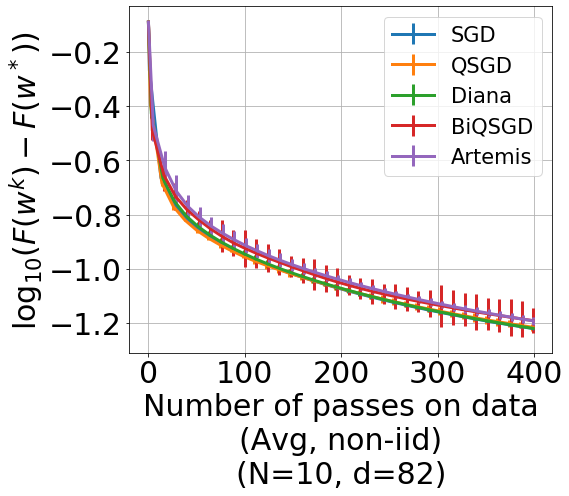

In [30]:
obj_min_by_N = pickle_loader(filename + "-noniid-obj_min")
res = pickle_loader(filename + "-noniid-descent")
obj = obj_min_by_N[len(X)]

plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, 
                dim_notebook, all_error=res.get_std(obj, averaged=False), 
                x_legend="Number of passes on data\n(Avg, non-iid)") 

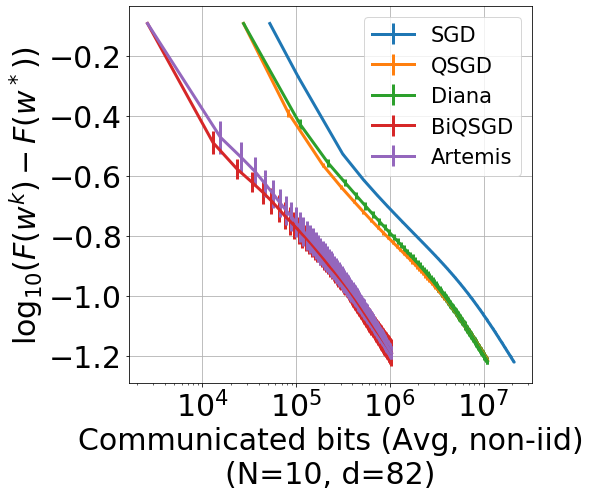

In [32]:
plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, dim_notebook, 
                x_points=res.X_number_of_bits, all_error=res.get_std(obj, averaged=True), 
                x_legend="Communicated bits (Avg, non-iid)") 


## Without averaging

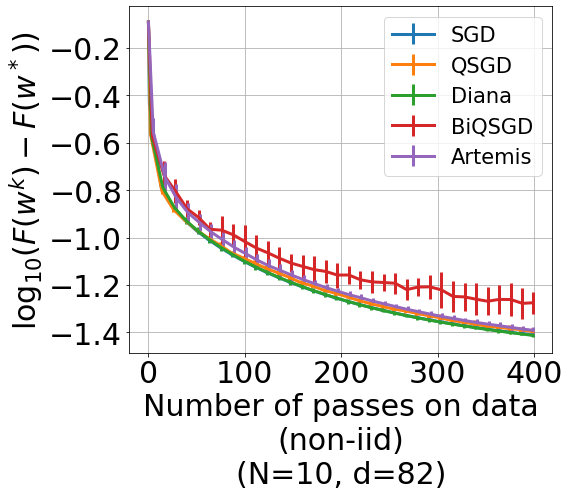

In [29]:
obj_min_by_N = pickle_loader(filename + "-noniid-obj_min")
res = pickle_loader(filename + "-noniid-descent")
obj = obj_min_by_N[len(X)]

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook,
                all_error=res.get_std(obj), x_legend="Number of passes on data\n(non-iid)") 

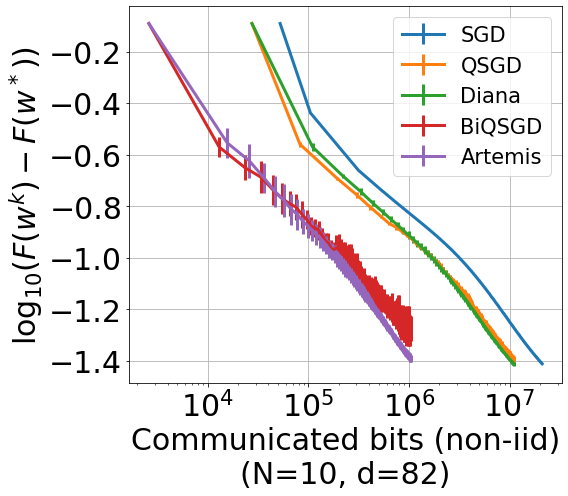

In [31]:
plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook, 
                x_points=res.X_number_of_bits, x_legend="Communicated bits (non-iid)", all_error=res.get_std(obj)) 